# Практика застосування kNN та Naive Bayes. EDA

### Знайомство з даними

In [80]:
import warnings
import pandas as pd
import numpy as np
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [17]:

# Завантаження навчального та валідаційного наборів даних
train_data = pd.read_csv('../datasets/mod_04_hw_train_data.csv')
valid_data = pd.read_csv('../datasets/mod_04_hw_valid_data.csv')

# Відображення перших кількох рядків навчального набору даних для огляду
train_data.head(), valid_data.head()


(                 Name  Phone_Number  Experience Qualification University  \
 0  Jennifer Hernandez  120-602-1220         3.0           Msc      Tier2   
 1      Timothy Walker  840-675-8650         5.0           PhD      Tier2   
 2         David Duran  556-293-8643         5.0           Msc      Tier2   
 3       Gloria Ortega  463-559-7474         3.0           Bsc      Tier3   
 4      Matthew Steele  968-091-7683         5.0           Bsc      Tier2   
 
      Role Cert Date_Of_Birth  Salary  
 0     Mid  Yes    25/08/1972   98000  
 1  Senior  Yes    03/12/2013  135500  
 2  Senior  Yes    19/07/2002  123500  
 3     Mid   No    19/02/1970   85000  
 4  Senior  Yes    20/02/1970  111500  ,
               Name  Phone_Number  Experience Qualification University    Role  \
 0   Alvaro Johnson  320-636-8883           7           Bsc      Tier1  Senior   
 1    Austin Powers  903-121-1691           2           Msc      Tier1     Mid   
 2      Joshua Phil  673-972-2453           3    

# Статистичний огляд навчального набору даних

In [34]:
train_stats = train_data.describe(include='all')
train_stats,

(               Name  Phone_Number  Experience Qualification University  \
 count           249           249  247.000000           248        249   
 unique          248           249         NaN             3          3   
 top     Eric Taylor  120-602-1220         NaN           Bsc      Tier1   
 freq              2             1         NaN           113         94   
 mean            NaN           NaN    3.441296           NaN        NaN   
 std             NaN           NaN    1.496471           NaN        NaN   
 min             NaN           NaN    1.000000           NaN        NaN   
 25%             NaN           NaN    2.000000           NaN        NaN   
 50%             NaN           NaN    4.000000           NaN        NaN   
 75%             NaN           NaN    5.000000           NaN        NaN   
 max             NaN           NaN    5.000000           NaN        NaN   
 
           Role Cert Date_Of_Birth  
 count      246  247           249  
 unique       3    2    

# Статистичний огляд валідаційного набору даних

In [36]:
valid_stats = valid_data.describe(include='all')

valid_stats


,Name,Phone_Number,Experience,Qualification,University,Role,Cert,Date_Of_Birth,Salary
count,7,7,7.0,7,7,7,7,7,7.000000
unique,7,7,NaN,3,3,3,2,7,NaN
top,Alvaro Johnson,320-636-8883,NaN,Bsc,Tier1,Junior,Yes,12/03/1978,NaN
freq,1,1,NaN,3,3,3,4,1,NaN
mean,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,93200.000000
std,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,17186.622705
min,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,69800.000000
25%,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,80300.000000
50%,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,97300.000000
75%,NaN,NaN,5.5,NaN,NaN,NaN,NaN,NaN,104100.000000


Перевірка  типів даних у тренувальному наборі

In [89]:
dtypes_train = train_data.dtypes
dtypes_train

Name              object
Phone_Number      object
Experience       float64
Qualification     object
University        object
Role              object
Cert              object
Date_Of_Birth     object
dtype: object

# Перевірка типів даних у валідаційному наборі

In [90]:
dtypes_valid = valid_data.dtypes
dtypes_valid 

Name             object
Phone_Number     object
Experience        int64
Qualification    object
University       object
Role             object
Cert             object
Date_Of_Birth    object
Salary            int64
dtype: object

Перевірка на відсутні значення в навчальному наборі

In [35]:
missing_values_train = train_data.isnull().sum()
missing_values_train, 

(Name             0
 Phone_Number     0
 Experience       2
 Qualification    1
 University       0
 Role             3
 Cert             2
 Date_Of_Birth    0
 dtype: int64,)

Перевірка на відсутні значення в валідаційному наборі

In [40]:
missing_values_valid = valid_data.isnull().sum()
missing_values_valid

Name             0
Phone_Number     0
Experience       0
Qualification    0
University       0
Role             0
Cert             0
Date_Of_Birth    0
Salary           0
dtype: int64

Нормалізація числових даних (Experience, Salary).

In [55]:
# Імп'ютери для числових і категоріальних даних
imputer_num = SimpleImputer(strategy='median')  # Медіана для числових даних
imputer_cat = SimpleImputer(strategy='most_frequent')  # Найчастіше значення для категоріальних даних

# Обробка відсутніх значень для числових полів
train_data['Experience'] = imputer_num.fit_transform(train_data[['Experience']])

Кодування категоріальних даних (Qualification, University, Role, Cert).

In [82]:
# Обробка відсутніх значень для категоріальних полів
# SimpleImputer може повертати 2D масив, тому використовуємо ravel() для перетворення у 1D масив перед присвоєнням назад у DataFrame
train_data['Qualification'] = imputer_cat.fit_transform(train_data[['Qualification']]).ravel()  # Використання ravel() для перетворення у 1D
train_data['Role'] = imputer_cat.fit_transform(train_data[['Role']]).ravel()  # Використання ravel() для перетворення у 1D
train_data['Cert'] = imputer_cat.fit_transform(train_data[['Cert']]).ravel()  # Використання ravel() для перетворення у 1D


Перевірка відсутніх значень після обробки

In [83]:
missing_values_updated = train_data.isnull().sum()
missing_values_updated

Name             0
Phone_Number     0
Experience       0
Qualification    0
University       0
Role             0
Cert             0
Date_Of_Birth    0
dtype: int64

KeyError: 'Salary'

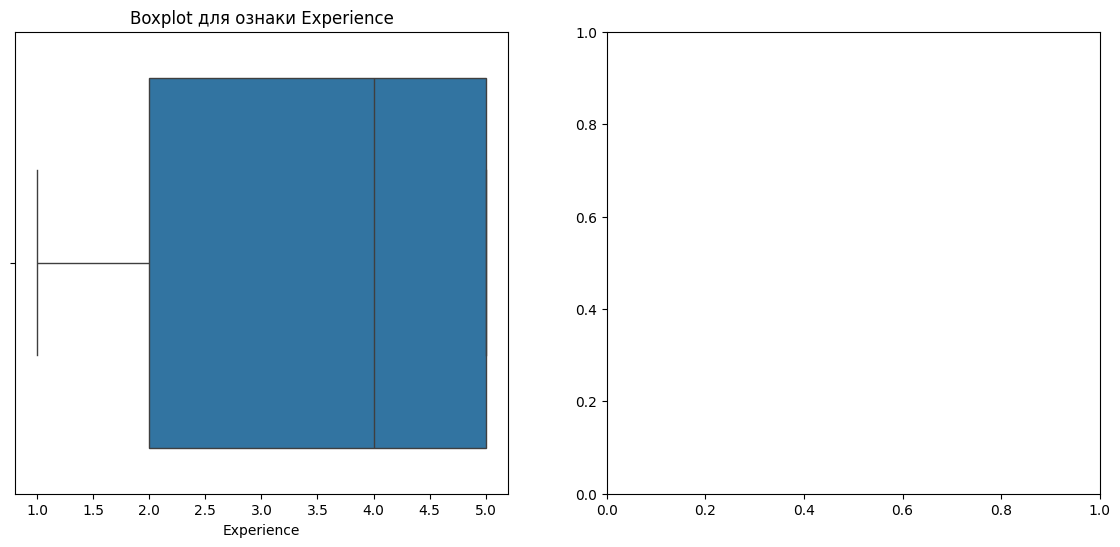

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# Аналіз викидів за допомогою boxplot
fig, axs = plt.subplots(ncols=2, figsize=(14, 6))
sns.boxplot(x=train_data['Experience'], ax=axs[0])
axs[0].set_title('Boxplot для ознаки Experience')

sns.boxplot(x=train_data['Salary'], ax=axs[1])
axs[1].set_title('Boxplot для ознаки Salary')

plt.show()

# Аналіз розподілу ознак
fig, axs = plt.subplots(ncols=2, figsize=(14, 6))
sns.histplot(train_data['Experience'], kde=True, ax=axs[0])
axs[0].set_title('Розподіл ознаки Experience')

sns.histplot(train_data['Salary'], kde=True, ax=axs[1])
axs[1].set_title('Розподіл ознаки Salary')

plt.show()

# Кореляційний аналіз числових ознак
correlation_matrix = train_data[['Experience', 'Salary']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Кореляційна матриця')
plt.show()



Побудова моделі kNN-регресора

In [24]:
train_data.drop('Salary', axis=1, inplace=True)

### Розподіл ознак

In [25]:
train_data.describe()

,Experience
count,247.000000
mean,3.441296
std,1.496471
min,1.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,5.000000


In [79]:
train_data.skew(numeric_only=True)

Experience   -0.397904
dtype: float64

# Практика застосування kNN та Naive Bayes. Підготовка й обробка даних

### Вимоги алгоритмів до обробки даних
### Очистка від викидів

In [69]:
train_updated_data = train_data[zscore(train_data['Experience']).abs().lt(2)]

### Видалення ознак, тісно пов`язаних з іншими ознаками

In [77]:
mtx = train_updated_data.drop('y', axis=1).corr(numeric_only=True).abs()

fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(mtx,
            cmap='crest',
            annot=True,
            fmt=".2f",
            linewidth=.5,
            mask=np.triu(np.ones_like(mtx, dtype=bool)),
            square=True,
            cbar=False,
            ax=ax)

KeyError: "['y'] not found in axis"

In [15]:
data.drop(
    ['emp.var.rate',
     'cons.price.idx',
     'cons.conf.idx',
     'nr.employed'],
    axis=1,
    inplace=True)

KeyError: "['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'nr.employed'] not found in axis"

### Огляд категоріальних ознак

In [9]:
data.select_dtypes(include='object').nunique()

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
y               2
dtype: int64

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    data['y'] = data['y'].replace({'no': 0, 'yes': 1})

### Розбиття на тренувальну і тестову вибірки

In [11]:
X_train, X_test, y_train, y_test = (
    train_test_split(
        data.drop('y', axis=1),
        data['y'],
        test_size=0.2,
        random_state=42))

### Кодування категоріальних змінних

In [12]:
cat_cols = X_train.select_dtypes(include='object').columns
cat_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [13]:
encoder = ce.WOEEncoder(cols=cat_cols)

X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

### Нормалізація змінних. Зменшення асиметрії

In [14]:
power_transform = PowerTransformer().set_output(transform='pandas')

X_train = power_transform.fit_transform(X_train)
X_test = power_transform.transform(X_test)

In [15]:
X_train.skew()

age            0.007984
job            0.048212
marital        0.826785
education      0.056809
default        2.514470
housing       -0.106005
loan          -1.703180
contact       -0.586952
month          0.104885
day_of_week   -0.179013
campaign       0.237176
pdays         -4.813348
previous       2.069751
poutcome       2.070238
euribor3m     -0.615990
dtype: float64

### Балансування класів

In [16]:
y_train.value_counts(normalize=True)

y
0    0.884514
1    0.115486
Name: proportion, dtype: float64

In [17]:
sm = SMOTE(random_state=42, k_neighbors=50)
X_res, y_res = sm.fit_resample(X_train, y_train)

# Практика застосування kNN та Naive Bayes. Побудова й оцінка моделей

### kNN-класифікатор

In [18]:
knn_mod = KNeighborsClassifier(n_neighbors=15, n_jobs=-1).fit(X_res, y_res)

knn_preds = knn_mod.predict(X_test)

knn_score = balanced_accuracy_score(y_test, knn_preds)

print(f'KNN model accuracy: {knn_score:.1%}')

KNN model accuracy: 70.7%


### Naive Bayes класифікатор

In [19]:
gnb_mod = GaussianNB().fit(X_res, y_res)

gnb_preds = gnb_mod.predict(X_test)

gnb_score = balanced_accuracy_score(y_test, gnb_preds)

print(f'GNB model accuracy: {gnb_score:.1%}')

GNB model accuracy: 71.2%


In [20]:
confusion_matrix(y_test, gnb_preds)

array([[5953, 1104],
       [ 381,  525]], dtype=int64)